#### 데이터 로드부터 시작

https://scikit-learn.org/stable/datasets/loading_other_datasets.html#sample-images

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
# tensorflow 용 시간체크와 tqdm
!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 23.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [162]:
# 흑백 이미지와 컬러 이미지를 위함
def plot_image(image):
    plt.imshow(image, cmap="copper", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [155]:
from sklearn.datasets import load_sample_image
# 샘플 이미지 - 중국 사원, 꽃
china = load_sample_image("china.jpg")/255
flower = load_sample_image("flower.jpg")/255

In [156]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
# filters = np.zeros(shape=(5,5,channels, 2), dtype=np.float32)
filters = np.zeros(shape=(7,7,channels, 2), dtype=np.float32)

In [157]:
# 수직선과 수평선
filters[:, 3, :, 0] = 1
filters[3:, :, :, 1] = 1

(-0.5, 639.5, 426.5, -0.5)

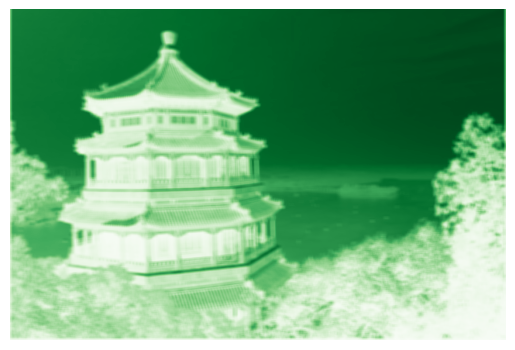

In [159]:
outputs = tf.nn.conv2d(images, filters, strides = 1, padding="SAME")
plt.imshow(outputs[0,:,:,1], cmap="Greens")
# 이미지의 feature map 반환
plt.show
plt.axis("off")

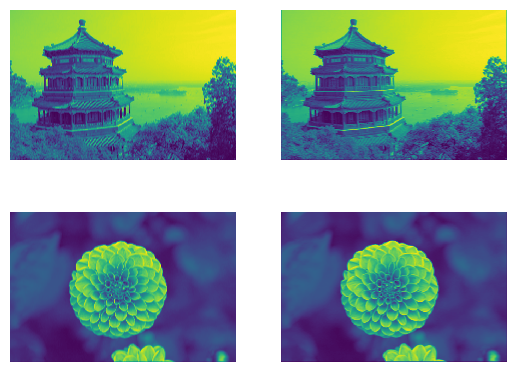

In [21]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_color_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [33]:
# 저장용 함수
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  if tight_layout:
      plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

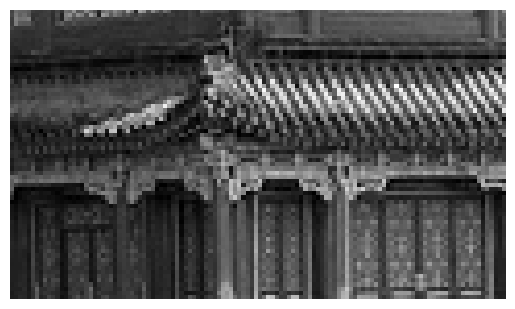

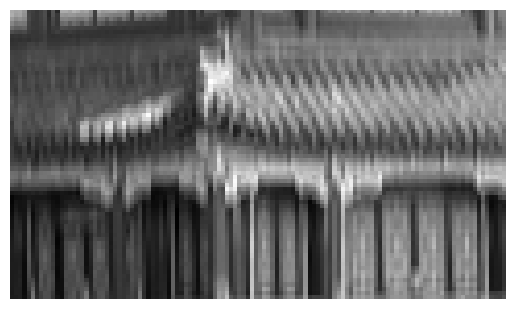

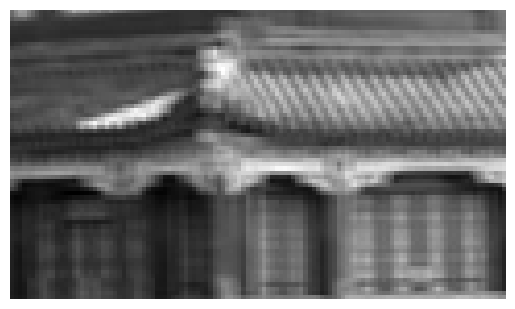

In [36]:
# 이미지 커팅
def crop(images):
    return images[150:220, 130:250]
# 수평, 수직 방향의 이미지 저장 및 인쇄
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

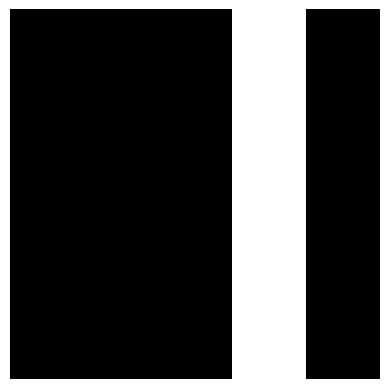

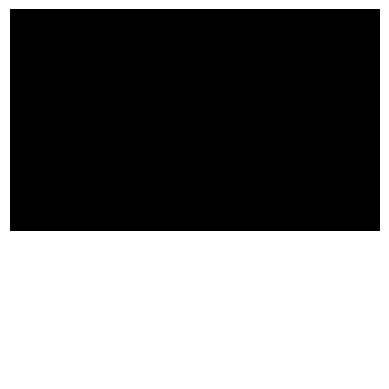

In [37]:
# 흑백
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [55]:
# CONV층 추가
conv= keras.layers.Conv2D(filters = 64, kernel_size=3, strides=1, padding="SAME", activation="relu",
                        input_shape=outputs.shape)

In [56]:
# 크기 확인
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 64])

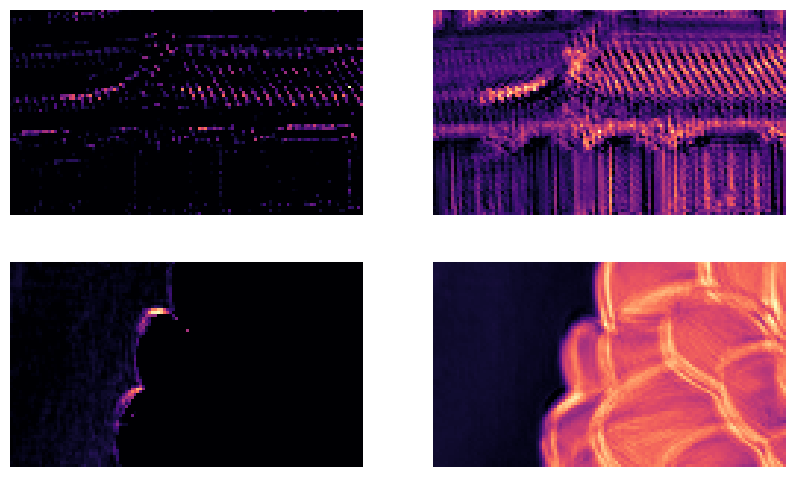

In [106]:
# 랜덤한 패턴 감지하는 피쳐 맵
conv= keras.layers.Conv2D(filters = 2, kernel_size=7, strides=1, padding="SAME", activation="relu",
                        input_shape=outputs.shape)
conv_outputs = conv(images)
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [107]:
# 편향 지정
conv.set_weights([filters, np.zeros(2)])

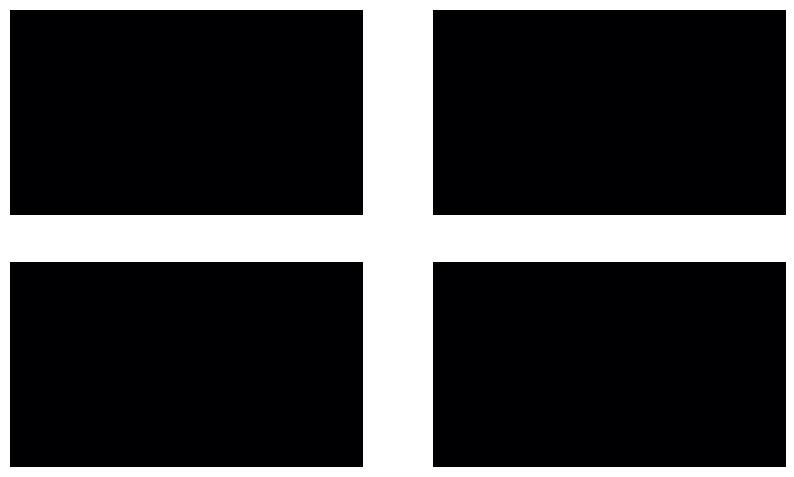

In [108]:
conv_outputs = conv(images)
conv_outputs.shape
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

#### valid and same 패딩

In [3]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [110]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_same의 가중치를 생성하기 위해 build() 메서드를 호출해야 합니다.
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_same으로 복사합니다.
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

#### pooling

In [4]:
# 맥스 풀링
max_pool= keras.layers.MaxPool2D(pool_size=1)

# output(CPU사용 필요)
output = tf.nn.max_pool(images, ksize = (1,1,1,3), strides=(1,1,1,3),
                        padding="VALID")

NameError: ignored

In [131]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

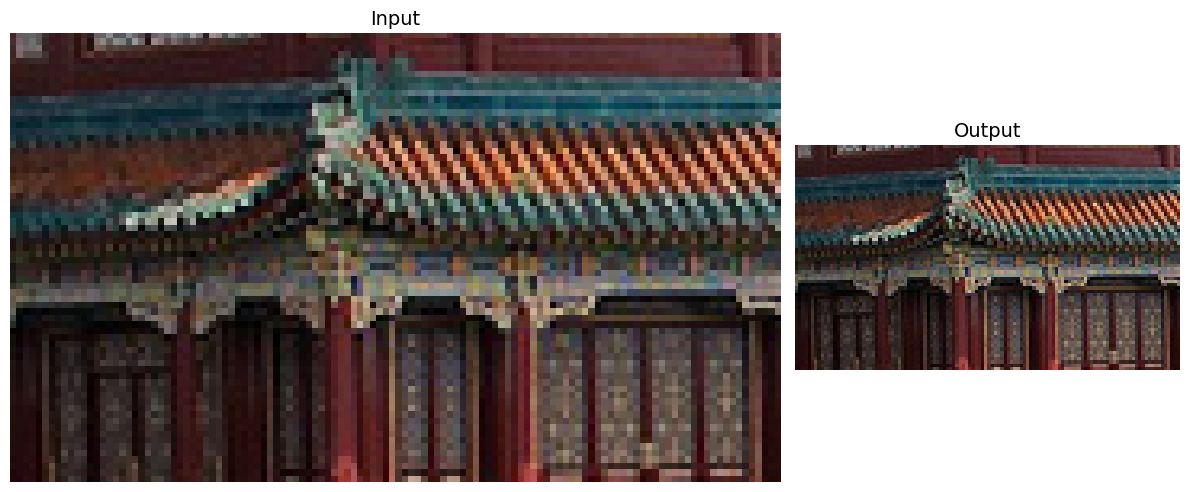

In [132]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

#### depth-wise 풀링

In [5]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [136]:
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize = (1,1,1,3), strides = (1,1,1,3),
                             padding="VALID")
)
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

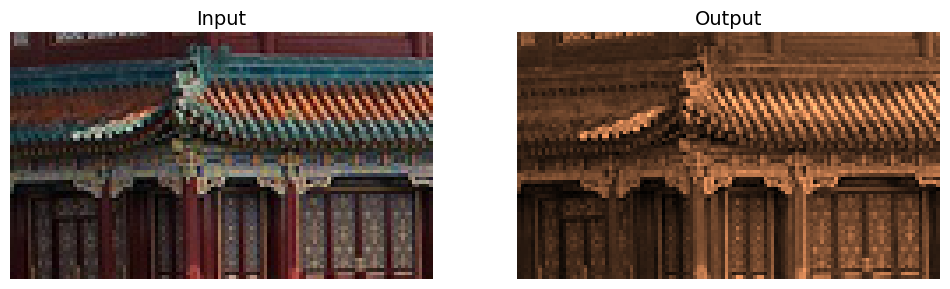

In [163]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()

#### 평균 풀링

In [170]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

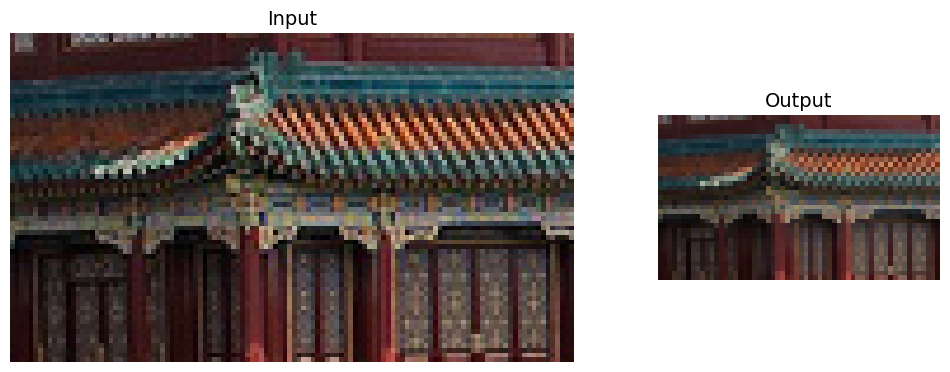

In [171]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

#### 전역 평균 풀링층

In [6]:
# 전역 평균 풀링층 정의
# global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1,2]))


In [172]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

#### CNN 전체적인 구조

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
# 함수 복사용 툴
from functools import partial

!pip install tensorflow-addons
import tqdm
import tensorflow_addons as tfa
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [11]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
# 1차 모델 컴파일

In [13]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), callbacks = tqdm_callback)
# 학습

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/1719           ETA: ?s - 

Epoch 1/20
1719/1719 [==============================] - 39s 11ms/step - loss: 0.7129 - accuracy: 0.7525 - val_loss: 0.3809 - val_accuracy: 0.8636
Epoch 2/20


0/1719           ETA: ?s - 

Epoch 2/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4313 - accuracy: 0.8556 - val_loss: 0.3468 - val_accuracy: 0.8756
Epoch 3/20


0/1719           ETA: ?s - 

Epoch 3/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3719 - accuracy: 0.8754 - val_loss: 0.3260 - val_accuracy: 0.8794
Epoch 4/20


0/1719           ETA: ?s - 

Epoch 4/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3383 - accuracy: 0.8872 - val_loss: 0.3123 - val_accuracy: 0.8866
Epoch 5/20


0/1719           ETA: ?s - 

Epoch 5/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3101 - accuracy: 0.8942 - val_loss: 0.3059 - val_accuracy: 0.8944
Epoch 6/20


0/1719           ETA: ?s - 

Epoch 6/20
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2969 - accuracy: 0.8993 - val_loss: 0.2842 - val_accuracy: 0.8974
Epoch 7/20


0/1719           ETA: ?s - 

Epoch 7/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2835 - accuracy: 0.9039 - val_loss: 0.2813 - val_accuracy: 0.9022
Epoch 8/20


0/1719           ETA: ?s - 

Epoch 8/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2807 - accuracy: 0.9051 - val_loss: 0.2852 - val_accuracy: 0.9028
Epoch 9/20


0/1719           ETA: ?s - 

Epoch 9/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2637 - accuracy: 0.9097 - val_loss: 0.2922 - val_accuracy: 0.8998
Epoch 10/20


0/1719           ETA: ?s - 

Epoch 10/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2645 - accuracy: 0.9104 - val_loss: 0.2988 - val_accuracy: 0.8962
Epoch 11/20


0/1719           ETA: ?s - 

Epoch 11/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2490 - accuracy: 0.9160 - val_loss: 0.3084 - val_accuracy: 0.8912
Epoch 12/20


0/1719           ETA: ?s - 

Epoch 12/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2344 - accuracy: 0.9204 - val_loss: 0.2938 - val_accuracy: 0.9046
Epoch 13/20


0/1719           ETA: ?s - 

Epoch 13/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2417 - accuracy: 0.9184 - val_loss: 0.3074 - val_accuracy: 0.8914
Epoch 14/20


0/1719           ETA: ?s - 

Epoch 14/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2345 - accuracy: 0.9203 - val_loss: 0.3031 - val_accuracy: 0.9028
Epoch 15/20


0/1719           ETA: ?s - 

Epoch 15/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2250 - accuracy: 0.9246 - val_loss: 0.2913 - val_accuracy: 0.9074
Epoch 16/20


0/1719           ETA: ?s - 

Epoch 16/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2205 - accuracy: 0.9265 - val_loss: 0.3068 - val_accuracy: 0.9040
Epoch 17/20


0/1719           ETA: ?s - 

Epoch 17/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2144 - accuracy: 0.9274 - val_loss: 0.3240 - val_accuracy: 0.9066
Epoch 18/20


0/1719           ETA: ?s - 

Epoch 18/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2191 - accuracy: 0.9260 - val_loss: 0.3110 - val_accuracy: 0.8886
Epoch 19/20


0/1719           ETA: ?s - 

Epoch 19/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2120 - accuracy: 0.9310 - val_loss: 0.3155 - val_accuracy: 0.8968
Epoch 20/20


0/1719           ETA: ?s - 

Epoch 20/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2139 - accuracy: 0.9279 - val_loss: 0.3274 - val_accuracy: 0.8996


In [ ]:
# 평가
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
X_new

In [16]:
# 예측값
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 95ms/step


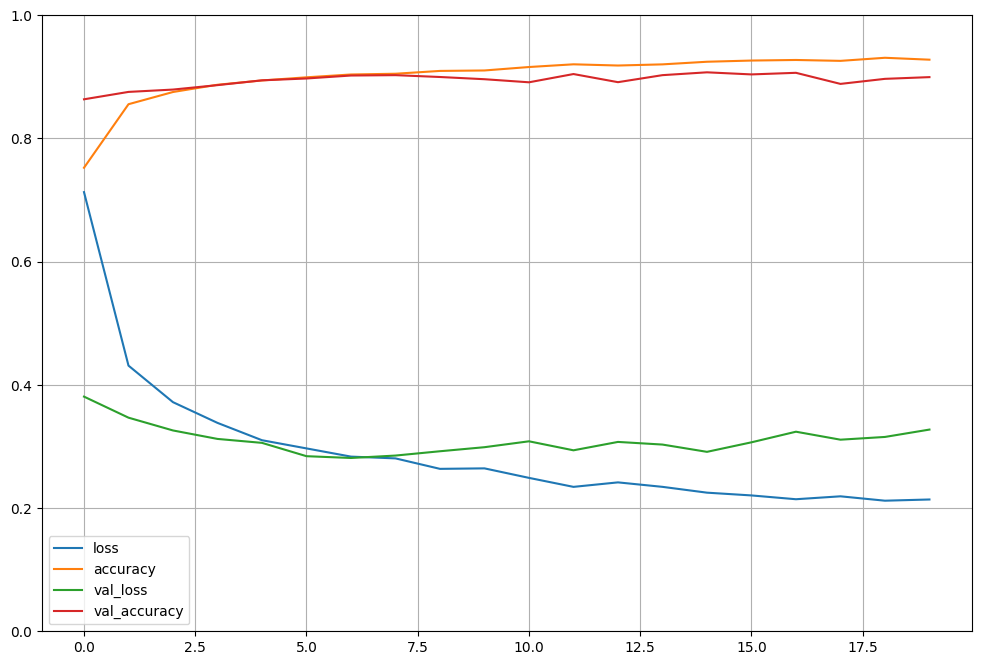

In [18]:
# 시각화
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [21]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation = "relu", padding = "same",
                        input_shape = [28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 6, activation = "relu", padding = "same"),
    keras.layers.Conv2D(256, 6, activation = "relu", padding = "same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="relu")
])

In [23]:
# 2차 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), callbacks = tqdm_callback)
# 학습

In [25]:
# 평가
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
# 예측값
y_pred = model.predict(X_new)
print(score, y_pred)

1/1 [==============================] - 0s 214ms/step
[2.30259108543396, 0.10000000149011612] [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


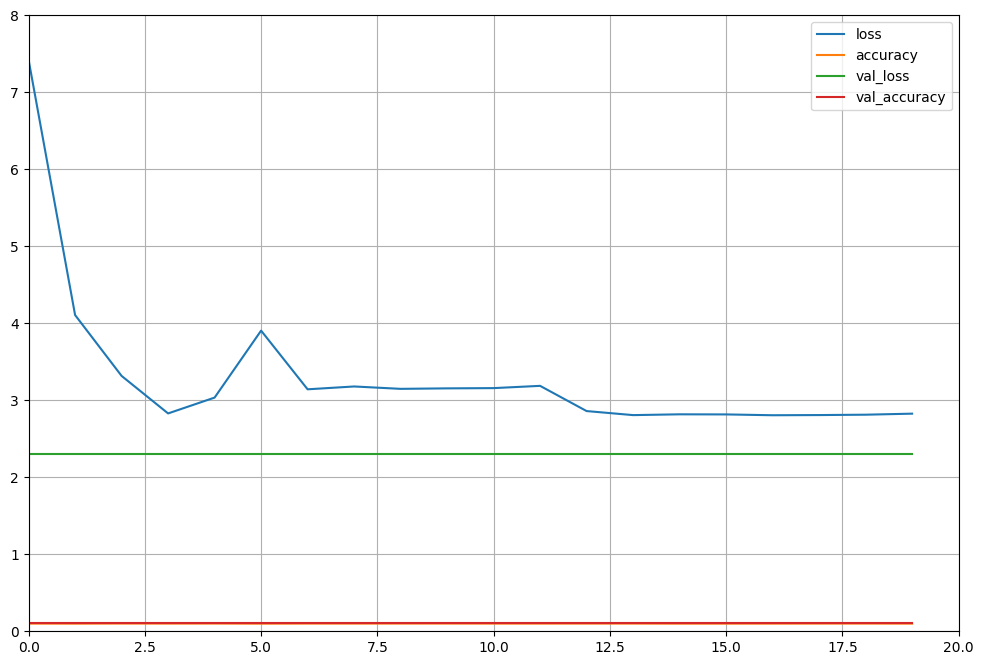

In [34]:
# 시각화
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,8)
plt.gca().set_xlim(0,20)
plt.show()

#### RESNET-34 시도

In [35]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [48]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[28, 28, 1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [49]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 14, 14, 64)        3136      
                                                                 
 batch_normalization_72 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 residual_unit_32 (ResidualU  (None, 7, 7, 64)         74240     
 nit)                                                            
                                                      

In [50]:
# RESNET 모델 "sequential_3" 컴파일
model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), callbacks = tqdm_callback)
# 학습

Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/1719           ETA: ?s - 

Epoch 1/20
1719/1719 [==============================] - 83s 38ms/step - loss: 1.9303 - accuracy: 0.4048 - val_loss: 1.1487 - val_accuracy: 0.6074
Epoch 2/20


0/1719           ETA: ?s - 

Epoch 2/20
 985/1719 [================>.............] - ETA: 23s - loss: 1.1287 - accuracy: 0.6177

In [ ]:
# 평가
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
# 예측값
y_pred = model.predict(X_new)
print(score, y_pred)

In [ ]:
# 시각화
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,8)
plt.gca().set_xlim(0,20)
plt.show()